В этом ноутбуке демонстрируется возможность сценарного моделирования отклика пользователей с помощью параметрической трехкомпонентной функции отклика:
$$f_{syn}(u_i, m_j)=Ber(\alpha_1Heur(u_i,m_j)+\alpha_2Real(u_i,m_j)+\alpha_3Random(u_i,m_j)),$$
$$\alpha_1+\alpha_2+\alpha_3=1; \alpha_1,\alpha_2,\alpha_3\in[0,1],$$
$$\forall u_i\in U_{syn}; \forall m_j \in M,$$
где $u_i$ –- вектор атрибутов пользователя, $m_j$ –- вектор атрибутов предложения, $U_{syn}$ –- набор синтетических профилей пользователей, $M$ –- набор профилей предложений, $Heur$ -– это эвристическая компонента (основанная на предположении о полезности действия пользователя), $Real$ –- компонента, которая моделирует отклик в наборе данных реального мира, $Random$ -– случайная компонента, $Ber$ -– распределение Бернулли, необходимое для добавления стохастики в характер формирования отклика.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import time

import pandas as pd

from pyspark.sql import SparkSession
from replay.session_handler import State

from sklearn.metrics import roc_auc_score, precision_score, recall_score

import pyspark.sql.functions as sf
import pyspark.ml.functions as smf
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml import Pipeline
from pyspark.ml.classification import (
    LogisticRegression, RandomForestClassifier
)

from replay.metrics import NDCG
from replay.data_preparator import Indexer
from ucb import UCB

from simulator.modules import (
    SDVDataGenerator, RealDataGenerator,
    Simulator, evaluate_synthetic,
    EvaluateMetrics
)
from simulator.response import (
    BernoulliResponse, ParametricResponseFunction,
    CosineSimilatiry, NoiseResponse
)
from simulator.utils import VectorElementExtractor, pandas_to_spark

from datautils import read_amazon

%matplotlib inline
import matplotlib.pyplot as plt

SPARK_LOCAL_DIR = '/data/home/anthony/tmp'
CHECKPOINT_DIR = '/data/home/anthony/tmp/checkpoints'
DATA_PATH = r'file:///mnt/dgxhome/home/estavinova/simulator/Amazon/home'
MODELS_DIR = '../bin'

spark = SparkSession.builder\
    .appName('netflix_surface')\
    .master('local[16]')\
    .config('spark.sql.shuffle.partitions', '16')\
    .config('spark.default.parallelism', '16')\
    .config('spark.driver.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.executor.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.sql.autoBroadcastJoinThreshold', '-1')\
    .config('spark.driver.memory', '128g')\
    .config('spark.local.dir', SPARK_LOCAL_DIR)\
    .getOrCreate()

State(spark)

22/11/23 11:54:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/11/23 11:54:36 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [2]:
def test_model(model_class, train_data, test_data, assembler, extractor):
    model = model_class(featuresCol='features', labelCol='relevance', probabilityCol='__prob_vec', predictionCol='response')

    start = time.time()
    pipeline = Pipeline(stages=[assembler, model, extractor]).fit(train_data)
    train_time = time.time() - start

    pred_pdf = pipeline\
        .transform(test_data)\
        .select('relevance', '__prob_raw', 'response')\
        .toPandas()

    roc_auc_model = roc_auc_score(pred_pdf.relevance, pred_pdf.__prob_raw)
    precision_model = precision_score(pred_pdf.relevance, pred_pdf.response)
    recall_model = recall_score(pred_pdf.relevance, pred_pdf.response)

    return train_time, pred_pdf,\
           {
            'roc_auc' : roc_auc_model,
            'precision' : precision_model,
            'recall' : recall_model
           }

Работаем с предобработанными данными, которые разделены на три части по времени выставления рейтинга. Оценки 1 и 2 считаем отрицательными (0); 3, 4 и 5 -- положительными (1).

Данные были предварительно предобработаны (код в папке Amazon): составлены профили польззователей и предложений по истории откликов, а также данные разделены по времени выставления оценок на обучающую, валидационную и тестовую выборки.

In [3]:
users_df_train, items_df_train, log_df_train = read_amazon(DATA_PATH, 'train', spark)

users_df_train = users_df_train.cache()
items_df_train = items_df_train.cache()
log_df_train = log_df_train.cache()

users_df_train.count()
items_df_train.count()
log_df_train.count()

22/11/23 11:55:18 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


14668620

In [4]:
users_df_val, items_df_val, log_df_val = read_amazon(DATA_PATH, 'val', spark)

users_df_val = users_df_val.cache()
items_df_val = items_df_val.cache()
log_df_val = log_df_val.cache()

users_df_val.count()
items_df_val.count()
log_df_val.count()

7377984

In [5]:
users_df_test, items_df_test, log_df_test = read_amazon(DATA_PATH, 'test', spark)

users_df_test = users_df_test.cache()
items_df_test = items_df_test.cache()
log_df_test = log_df_test.cache()

users_df_test.count()
items_df_test.count()
log_df_test.count()

7399807

# Генерация эмбеддингов

В результате экспериментального исследования методов генерации эмбеддингов (amazon_embeddings.ipynb) было решено использовать метод главных компонент в случае датасета Amazon. Далее с помощью этого метода генерируются профили пользователей.

Также были сгенерированы профили предложений, так как одна из компонент функции отклика (эвристическая) предполагает, что профили пользователей и предложений -- это векторы в одном и том же пространстве.

In [6]:
pca_va = VectorAssembler(
    inputCols=['user_helpfulness', 'user_rating_avg'] + [f'user_w2v_{i}' for i in range(300)],
    outputCol='features'
)
pca_estimator = PCA(k=10, inputCol='features', outputCol='pca_features')

pca = Pipeline(stages=[pca_va, pca_estimator]).fit(users_df_train)

22/11/23 11:59:02 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/11/23 11:59:02 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
22/11/23 11:59:18 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/11/23 11:59:18 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [7]:
users_df_train_new = pca.transform(users_df_train)\
    .select('user_id', 'pca_features')\
    .withColumn('user_features', smf.vector_to_array('pca_features'))\
    .select(['user_id'] + [sf.col('user_features')[i] for i in range(10)])\
    .cache()

users_df_train.unpersist()
users_df_train = users_df_train_new

users_df_val_new = pca.transform(users_df_val)\
    .select('user_id', 'pca_features')\
    .withColumn('user_features', smf.vector_to_array('pca_features'))\
    .select(['user_id'] + [sf.col('user_features')[i] for i in range(10)])\
    .cache()

users_df_val.unpersist()
users_df_val = users_df_val_new

pca_va.setInputCols(['item_helpfulness', 'item_rating_avg'] + [f'item_w2v_{i}' for i in range(300)])

items_df_train_new = pca.transform(items_df_train)\
    .select('item_id', 'pca_features')\
    .withColumn('item_features', smf.vector_to_array('pca_features'))\
    .select(['item_id'] + [sf.col('item_features')[i] for i in range(10)])\
    .cache()

items_df_train.unpersist()
items_df_train = items_df_train_new

items_df_val_new = pca.transform(items_df_val)\
    .select('item_id', 'pca_features')\
    .withColumn('item_features', smf.vector_to_array('pca_features'))\
    .select(['item_id'] + [sf.col('item_features')[i] for i in range(10)])\
    .cache()

items_df_val.unpersist()
items_df_val = items_df_val_new

# Обучение генератора

Также в ноутбуке amazon_embeddings.ipynb был сделан вывод о том, что модель генерации CopulaGAN является наиболее подходящей в случае датасета Amazon и эмбеддингов на основе PCA. Поэтому здесь будет использована именно эта модель.

In [8]:
# user_generator = SDVDataGenerator(
#     label='synth_user',
#     id_column_name='user_id',
#     model_name='copulagan',
#     parallelization_level=8,
#     device_name='cpu',
#     seed=1234
# )

# user_generator.fit(users_df_train)
# user_generator.save_model(f'{MODELS_DIR}/amazon_pca_users_copulagan.pkl')

user_generator = SDVDataGenerator.load(f'{MODELS_DIR}/amazon_pca_users_copulagan.pkl')
user_generator.setDevice('cpu')
user_generator.setParallelizationLevel(16)

users_synth = user_generator.generate(80650)

gen_score = evaluate_synthetic(
    synth_df=users_synth.sample(1000 / user_generator.getDataSize()).drop('user_id'),
    real_df=users_df_train.sample(1000 / users_df_train.count()).drop('user_id')
)

gen_score

{'LogisticDetection': 0.5875090505080767,
 'SVCDetection': 0.44502596559558594,
 'KSTest': 0.9035521683769006,
 'ContinuousKLDivergence': 0.7433016804086007}

In [9]:
item_generator = RealDataGenerator(label='real_item', seed=1234)
item_generator.fit(items_df_train)
_ = item_generator.generate(27278)

22/11/23 11:59:53 WARN CacheManager: Asked to cache already cached data.


# Инициализация симулятора

In [10]:
simulator = Simulator(
    user_gen=user_generator,
    item_gen=item_generator,
    user_key_col='user_id',
    item_key_col='item_id',
    spark_session=spark,
    data_dir=f'{CHECKPOINT_DIR}/amazon_surface'
)

# Обучение регрессии

В ноутбуке amazon_response.ipynb было замечено, что логистическая регрессия дает лучшее качество с точки зрения ROC-AUC и Precision по сравнению с двумя другими моделями. Кроме того, она обучается заметно быстрее, чем матричная факторизация. Поэтому эта модель была выбрана для реализации компоненты Real функции отклика.

Напомним, что профили пользователей и предложений, относящиеся к периоду train (users_df_train и items_df_train соответственно) построены по истории взаимодействий из log_df_train. Поэтому для обучения модели отклика используются профили пользователей users_df_train и предложений items_df_train, а также лог log_df_val. Для оценки качества модели отклика используются профили users_df_val и items_df_val, построенные по объединенному логу log_df_train и log_df_val, а также лог log_df_test.

In [11]:
feature_cols = [f'user_features[{i}]' for i in range(10)] +\
               [f'item_features[{i}]' for i in range(10)]

assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
extractor = VectorElementExtractor(inputCol='__prob_vec', outputCol='__prob_raw', index=1)

train_df = log_df_val\
    .sample(100000 / log_df_val.count())\
    .drop('timestamp')\
    .join(users_df_train, on='user_id', how='left')\
    .join(items_df_train, on='item_id', how='left')\
    .na.drop()\
    .cache()

test_df = log_df_test\
    .sample(100000 / log_df_test.count())\
    .drop('timestamp')\
    .join(users_df_val, on='user_id', how='left')\
    .join(items_df_val, on='item_id', how='left')\
    .na.drop()\
    .cache()

# Качество логистической регрессии

In [12]:
lr_time, lr_pdf, lr_model_metrics = test_model(
    model_class=LogisticRegression,
    train_data=train_df,
    test_data=test_df,
    assembler=assembler,
    extractor=extractor
)

LogisticRegression pipeline train time: 36.034642457962036
LogisticRegression metrics: {'roc_auc': 0.7113990927693762, 'precision': 0.8821998264699993, 'recall': 0.9911889317985827}


<AxesSubplot: >

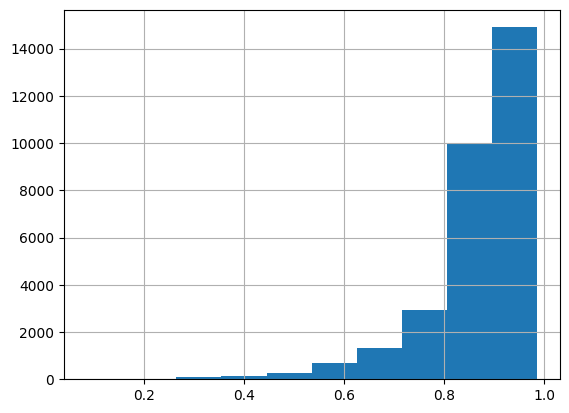

In [13]:
print(f'LogisticRegression pipeline train time: {lr_time}')
print(f'LogisticRegression metrics: {lr_model_metrics}')

lr_pdf['__prob_raw'].hist()

# Качество случайного леса

In [14]:
rf_time, rf_pdf, rf_model_metrics = test_model(
    model_class=RandomForestClassifier,
    train_data=train_df,
    test_data=test_df,
    assembler=assembler,
    extractor=extractor
)

RandomForestClassifier pipeline train time: 7.564281940460205
RandomForestClassifier metrics: {'roc_auc': 0.7098965828621955, 'precision': 0.8784625012351371, 'recall': 1.0}


<AxesSubplot: >

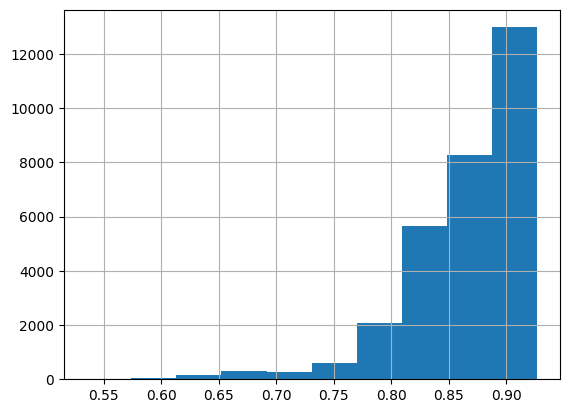

In [15]:
print(f'RandomForestClassifier pipeline train time: {rf_time}')
print(f'RandomForestClassifier metrics: {rf_model_metrics}')

rf_pdf['__prob_raw'].hist()

# Обучение рексистемы

Далее будем в цикле обучать рекомендательную систему на откликах синтетических пользователей, полученных с помощью симулятора.

In [16]:
lr = LogisticRegression(featuresCol='features', labelCol='relevance', probabilityCol='__prob_vec')

va_users = VectorAssembler(inputCols=[f'user_features[{i}]' for i in range(10)], outputCol='features_usr')
va_items = VectorAssembler(inputCols=[f'item_features[{i}]' for i in range(10)], outputCol='features_itm')

heur_resp = CosineSimilatiry(inputCols=['features_usr', 'features_itm'], outputCol='__cosine_resp')
noise_resp = NoiseResponse(mu=0.5, sigma=0.2, outputCol='__noise_resp', seed=1234)

resp_func = ParametricResponseFunction(
    inputCols=['__prob_raw', '__cosine_resp', '__noise_resp'],
    outputCol='__prob',
    weights=[1.0, 0.0, 0.0]
)

bernoulli = BernoulliResponse(inputCol='__prob', outputCol='response', seed=1234)

pipeline = Pipeline(stages=[assembler, lr, extractor, va_users, va_items, heur_resp, noise_resp, resp_func, bernoulli]).fit(train_df)

In [17]:
indexer = Indexer(user_col='user_id', item_col='item_id')
indexer.fit(users=user_generator.sample(1.0), items=item_generator.sample(1.0))

dummy_log = pandas_to_spark(pd.DataFrame({'user_idx' : [1], 'item_idx' : [1], 'relevance' : [0.0]}))

In [18]:
evaluator = EvaluateMetrics(
    userKeyCol='user_id',
    itemKeyCol='item_id',
    predictionCol='relevance',
    labelCol='response',
    replay_label_filter=1.0,
    replay_metrics={NDCG() : 10}
)

In [19]:
DISC = 10

alphas = []
for a1 in range(DISC + 1):
    for a2 in range(DISC - a1 + 1):
        a3 = DISC - a1 - a2

        a_sum = (a1 + a2 + a3) * 4
        alphas.append([a1 / a_sum, a2 / a_sum, a3 / a_sum])

user_frac = 10000 / user_generator.getDataSize()
item_frac = 0.4

In [29]:
users_replay = indexer.transform(user_generator.sample(1.0)).cache()
items_replay = indexer.transform(item_generator.sample(1.0)).cache()

spark.sparkContext.setLogLevel('ERROR')

Далее будем в цикле обучать рекомендательную систему на откликах синтетических пользователей, полученных с помощью симулятора, в течение 100 итераций. Затем будем считать значение метрики NDCG@10 для обученной рексистемы и переходить к следующей комбинации параметров функции отклика.

In [ ]:
surface_ndcg = []

for a in alphas:
    resp_func.setWeights(a)
    simulator.log_filename = f'log_{"_".join([str(a_i * 4) for a_i in a])}.parquet'

    ucb = UCB(sample=True)
    ucb.fit(dummy_log)

    print(f'Current weights: {a}')

    for i in range(100):
        iter_start = time.time()

        # users = simulator.sample_users(user_frac).cache()
        # items = simulator.sample_items(item_frac).cache()
        users = users_replay.sample(user_frac).withColumnRenamed('user_idx', 'user_id').cache()
        items = items_replay.sample(item_frac).withColumnRenamed('item_idx', 'item_id').cache()
        log = simulator.get_log(users)
        log = dummy_log.withColumnRenamed('user_idx', 'user_id').withColumnRenamed('item_idx', 'item_id') if log is None else log
        log = log.cache()

        recs_ucb = ucb.predict(
            log=log.withColumnRenamed('user_id', 'user_idx').withColumnRenamed('item_id', 'item_idx'),
            k=10,
            users=users.withColumnRenamed('user_id', 'user_idx'),
            items=items.withColumnRenamed('item_id', 'item_idx'),
            filter_seen_items=False
        )
        recs_ucb = recs_ucb.withColumnRenamed('user_idx', 'user_id').withColumnRenamed('item_idx', 'item_id').cache()

        resp_ucb = simulator.sample_responses(
            recs_df=recs_ucb,
            user_features=users,
            item_features=items,
            action_models=pipeline
        ).select('user_id', 'item_id', 'relevance', 'response').cache()

        simulator.update_log(resp_ucb, iteration=i)

        ucb._clear_cache()
        ucb_train_log = simulator.log.cache()
        ucb.fit(log=ucb_train_log.select('user_id', 'item_id', 'response').withColumnRenamed('user_id', 'user_idx').withColumnRenamed('item_id', 'item_idx').withColumnRenamed('response', 'relevance'))

        users.unpersist()
        items.unpersist()
        log.unpersist()
        recs_ucb.unpersist()
        resp_ucb.unpersist()
        ucb_train_log.unpersist()

        print(f'Iteration {i} finished in {time.time() - iter_start} sec.')

    users = users_replay.sample(user_frac).withColumnRenamed('user_idx', 'user_id').cache()
    items = items_replay.sample(item_frac).withColumnRenamed('item_idx', 'item_id').cache()
    log = simulator.get_log(users).cache()

    recs_ucb = ucb.predict(
        log=log.withColumnRenamed('user_id', 'user_idx').withColumnRenamed('item_id', 'item_idx'),
        k=10,
        users=users.withColumnRenamed('user_id', 'user_idx'),
        items=items.withColumnRenamed('item_id', 'item_idx'),
        filter_seen_items=False
    )
    recs_ucb = recs_ucb.withColumnRenamed('user_idx', 'user_id').withColumnRenamed('item_idx', 'item_id').cache()

    resp_ucb = simulator.sample_responses(
        recs_df=recs_ucb,
        user_features=users,
        item_features=items,
        action_models=pipeline
    ).select('user_id', 'item_id', 'relevance', 'response').cache()

    metrics = evaluator(resp_ucb)

    users.unpersist()
    items.unpersist()
    log.unpersist()
    recs_ucb.unpersist()
    resp_ucb.unpersist()

    surface_ndcg.append({
        'LR' : a[0], 'cosine' : a[1],
        'noise' : a[2], 'ndcg' : metrics['NDCG@10']
    })
    
    surface_pdf = pd.DataFrame(surface_ndcg)
    surface_pdf.to_csv('../bin/amazon_surface_ndcg.csv', index=False)

Current weights: [0.15, 0.0, 0.1]


Iteration 0 finished in 19.184749603271484 sec.


Iteration 1 finished in 13.2987060546875 sec.


Iteration 2 finished in 13.745073318481445 sec.


Iteration 3 finished in 12.601804256439209 sec.


Iteration 4 finished in 12.243556022644043 sec.


Iteration 5 finished in 11.902015209197998 sec.


Iteration 6 finished in 13.142573833465576 sec.


Iteration 7 finished in 11.722174167633057 sec.


Iteration 8 finished in 11.845501184463501 sec.


Iteration 9 finished in 12.567521095275879 sec.


Iteration 10 finished in 12.070052146911621 sec.


Iteration 11 finished in 12.171682596206665 sec.


Iteration 12 finished in 11.396940231323242 sec.


Iteration 13 finished in 11.497194766998291 sec.


Iteration 14 finished in 12.825220584869385 sec.


Iteration 15 finished in 12.098788976669312 sec.


Iteration 16 finished in 12.158772945404053 sec.


Iteration 17 finished in 12.797498941421509 sec.


Iteration 18 finished in 11.87725019454956 sec.


Iteration 19 finished in 12.144031763076782 sec.


Iteration 20 finished in 12.175801753997803 sec.


Iteration 21 finished in 12.144566297531128 sec.


Iteration 22 finished in 12.118683099746704 sec.


Iteration 23 finished in 12.551660060882568 sec.


Iteration 24 finished in 14.184726476669312 sec.


Iteration 25 finished in 12.684268712997437 sec.


Iteration 26 finished in 12.379430055618286 sec.


Iteration 27 finished in 12.983893632888794 sec.


Iteration 28 finished in 12.53782844543457 sec.


Iteration 29 finished in 12.631207466125488 sec.


Iteration 30 finished in 12.226241827011108 sec.


Iteration 31 finished in 11.778730154037476 sec.


Iteration 32 finished in 13.98072600364685 sec.


Iteration 33 finished in 14.0911705493927 sec.


Iteration 34 finished in 12.689764976501465 sec.


Iteration 35 finished in 13.909902334213257 sec.


Iteration 36 finished in 12.947666883468628 sec.


Iteration 37 finished in 12.806976318359375 sec.


Iteration 38 finished in 12.295948266983032 sec.


Iteration 39 finished in 13.411726713180542 sec.


Iteration 40 finished in 13.071000814437866 sec.


Iteration 41 finished in 12.88911747932434 sec.


Iteration 42 finished in 13.032711505889893 sec.


Iteration 43 finished in 13.059632062911987 sec.


Iteration 44 finished in 12.904990911483765 sec.


Iteration 45 finished in 12.617587804794312 sec.


Iteration 46 finished in 12.727740287780762 sec.


Iteration 47 finished in 13.885298013687134 sec.


Iteration 48 finished in 13.345796823501587 sec.


Iteration 49 finished in 13.035865306854248 sec.


Iteration 50 finished in 36.28945255279541 sec.


Iteration 51 finished in 14.274551153182983 sec.


Iteration 52 finished in 17.40769648551941 sec.


Iteration 53 finished in 15.66606330871582 sec.


Iteration 54 finished in 13.953922748565674 sec.


Iteration 55 finished in 14.093969345092773 sec.


Iteration 56 finished in 13.702481269836426 sec.


Iteration 57 finished in 15.567409992218018 sec.


Iteration 58 finished in 13.75576400756836 sec.


Iteration 59 finished in 14.656569004058838 sec.


Iteration 60 finished in 15.216795682907104 sec.


Iteration 61 finished in 12.78891658782959 sec.


Iteration 62 finished in 13.349741458892822 sec.


Iteration 63 finished in 15.166704654693604 sec.


Iteration 64 finished in 15.823868751525879 sec.


Iteration 65 finished in 13.683473587036133 sec.


Iteration 66 finished in 13.70758605003357 sec.


Iteration 67 finished in 15.708646774291992 sec.


Iteration 68 finished in 16.1448655128479 sec.


Iteration 69 finished in 14.721364974975586 sec.


Iteration 70 finished in 13.972033262252808 sec.


Iteration 71 finished in 15.785006761550903 sec.


Iteration 72 finished in 14.972156763076782 sec.


Iteration 73 finished in 13.394456624984741 sec.


Iteration 74 finished in 15.257231712341309 sec.


Iteration 75 finished in 14.970613241195679 sec.


Iteration 76 finished in 14.339795351028442 sec.


Iteration 77 finished in 13.984185218811035 sec.


Iteration 78 finished in 13.680566310882568 sec.


Iteration 79 finished in 13.505295991897583 sec.


Iteration 80 finished in 14.982760906219482 sec.


Iteration 81 finished in 14.206780433654785 sec.


Iteration 82 finished in 14.063472270965576 sec.


Iteration 83 finished in 16.309401273727417 sec.


Iteration 84 finished in 13.748588562011719 sec.


Iteration 85 finished in 13.689912557601929 sec.


Iteration 86 finished in 13.89394235610962 sec.


Iteration 87 finished in 13.832802057266235 sec.


Iteration 88 finished in 17.64509868621826 sec.


Iteration 89 finished in 14.767620086669922 sec.


Iteration 90 finished in 16.18867826461792 sec.


Iteration 91 finished in 14.511765718460083 sec.


Iteration 92 finished in 13.797096252441406 sec.


Iteration 93 finished in 15.27735447883606 sec.


Iteration 94 finished in 14.822140216827393 sec.


Iteration 95 finished in 16.25320315361023 sec.


Iteration 96 finished in 14.242142677307129 sec.


Iteration 97 finished in 14.996935844421387 sec.


Iteration 98 finished in 15.075803279876709 sec.


Iteration 99 finished in 16.959743976593018 sec.


Current weights: [0.15, 0.025, 0.075]


Iteration 0 finished in 12.569460391998291 sec.


Iteration 1 finished in 12.213152408599854 sec.


Iteration 2 finished in 11.746330738067627 sec.


Iteration 3 finished in 11.95727825164795 sec.


Iteration 4 finished in 12.245963335037231 sec.


Iteration 5 finished in 11.484429597854614 sec.


Iteration 6 finished in 11.957848310470581 sec.


Iteration 7 finished in 11.794116258621216 sec.


Iteration 8 finished in 12.342710494995117 sec.


Iteration 9 finished in 11.832316637039185 sec.


Iteration 10 finished in 11.904241800308228 sec.


Iteration 11 finished in 14.660664796829224 sec.


Iteration 12 finished in 12.55171799659729 sec.


Iteration 13 finished in 11.774276494979858 sec.


Iteration 14 finished in 12.398083925247192 sec.


Iteration 15 finished in 12.749603033065796 sec.


Iteration 16 finished in 11.135567426681519 sec.


Iteration 17 finished in 12.234103679656982 sec.


Iteration 18 finished in 12.216167688369751 sec.


Iteration 19 finished in 11.839167833328247 sec.


Iteration 20 finished in 12.637995719909668 sec.


Iteration 21 finished in 12.861141443252563 sec.


Iteration 22 finished in 11.83026933670044 sec.


Iteration 23 finished in 13.816676616668701 sec.


Iteration 24 finished in 13.131988048553467 sec.


Iteration 25 finished in 12.461514711380005 sec.


Iteration 26 finished in 12.694186210632324 sec.


Iteration 27 finished in 12.443126440048218 sec.


Iteration 28 finished in 13.069981098175049 sec.


Iteration 29 finished in 13.27579379081726 sec.


Iteration 30 finished in 11.918821334838867 sec.


Iteration 31 finished in 12.260766983032227 sec.


Iteration 32 finished in 12.583518981933594 sec.


Iteration 33 finished in 13.956300497055054 sec.


Iteration 34 finished in 13.558273553848267 sec.


Iteration 35 finished in 15.684683322906494 sec.


Iteration 36 finished in 13.195429563522339 sec.


Iteration 37 finished in 13.271377801895142 sec.


Iteration 38 finished in 13.276962757110596 sec.


Iteration 39 finished in 12.82012939453125 sec.


Iteration 40 finished in 13.834112405776978 sec.


Iteration 41 finished in 14.094653844833374 sec.


Iteration 42 finished in 12.881762742996216 sec.


Iteration 43 finished in 13.714540481567383 sec.


Iteration 44 finished in 15.836704730987549 sec.


Iteration 45 finished in 13.834281206130981 sec.


Iteration 46 finished in 13.702213287353516 sec.


Iteration 47 finished in 14.197439670562744 sec.


Iteration 48 finished in 13.034276247024536 sec.


Iteration 49 finished in 13.318811893463135 sec.


Iteration 50 finished in 14.196701526641846 sec.


Iteration 51 finished in 12.764766931533813 sec.


Iteration 52 finished in 17.484216451644897 sec.


Iteration 53 finished in 13.253990650177002 sec.


Iteration 54 finished in 13.29078459739685 sec.


Iteration 55 finished in 14.314023494720459 sec.


Iteration 56 finished in 12.807156562805176 sec.


Iteration 57 finished in 14.637569189071655 sec.


Iteration 58 finished in 12.923364877700806 sec.


Iteration 59 finished in 14.239475727081299 sec.


Iteration 60 finished in 12.667163610458374 sec.


Iteration 61 finished in 12.65159010887146 sec.


Iteration 62 finished in 13.807439804077148 sec.


Iteration 63 finished in 13.497957944869995 sec.


Iteration 64 finished in 16.03011989593506 sec.


Iteration 65 finished in 13.896162271499634 sec.


Iteration 66 finished in 14.076117038726807 sec.


Iteration 67 finished in 14.349618911743164 sec.


Iteration 68 finished in 13.622217655181885 sec.


Iteration 69 finished in 13.235689640045166 sec.


Iteration 70 finished in 14.74402642250061 sec.


Iteration 71 finished in 14.019317150115967 sec.


Iteration 72 finished in 17.80240273475647 sec.


Iteration 73 finished in 14.151822090148926 sec.


Iteration 74 finished in 13.740898609161377 sec.


Iteration 75 finished in 14.55981707572937 sec.


Iteration 76 finished in 15.042098760604858 sec.


Iteration 77 finished in 31.307411432266235 sec.


Iteration 78 finished in 15.181605577468872 sec.


Iteration 79 finished in 16.939638137817383 sec.


Iteration 80 finished in 16.74417209625244 sec.


Iteration 81 finished in 14.262300729751587 sec.


Iteration 82 finished in 14.350532054901123 sec.


Iteration 83 finished in 13.859559535980225 sec.


Iteration 84 finished in 14.502645492553711 sec.


Iteration 85 finished in 14.713809728622437 sec.


Iteration 86 finished in 15.924392700195312 sec.


Iteration 87 finished in 15.454853534698486 sec.


Iteration 88 finished in 15.055049180984497 sec.


Iteration 89 finished in 15.871026039123535 sec.


Iteration 90 finished in 14.184738397598267 sec.


Iteration 91 finished in 14.496209383010864 sec.


Iteration 92 finished in 18.47807550430298 sec.


Iteration 93 finished in 14.355823755264282 sec.


Iteration 94 finished in 17.10837435722351 sec.


Iteration 95 finished in 15.449610471725464 sec.


Iteration 96 finished in 16.060067653656006 sec.


Iteration 97 finished in 15.217566728591919 sec.


Iteration 98 finished in 14.987550735473633 sec.


Iteration 99 finished in 15.570959091186523 sec.


Current weights: [0.15, 0.05, 0.05]


Iteration 0 finished in 12.560327529907227 sec.


Iteration 1 finished in 10.95921802520752 sec.


Iteration 2 finished in 11.257697105407715 sec.


Iteration 3 finished in 11.423617362976074 sec.


Iteration 4 finished in 11.080965280532837 sec.


Iteration 5 finished in 11.694188833236694 sec.


Iteration 6 finished in 11.45873212814331 sec.


Iteration 7 finished in 13.118633270263672 sec.


Iteration 8 finished in 13.247611999511719 sec.


Iteration 9 finished in 12.516816139221191 sec.


Iteration 10 finished in 12.123324632644653 sec.


Iteration 11 finished in 13.143524169921875 sec.


Iteration 12 finished in 16.223456621170044 sec.


Iteration 13 finished in 12.39672327041626 sec.


Iteration 14 finished in 12.1376473903656 sec.


Iteration 15 finished in 12.469722747802734 sec.


Iteration 16 finished in 12.024584531784058 sec.


Iteration 17 finished in 12.116313457489014 sec.


Iteration 18 finished in 12.383179903030396 sec.


Iteration 19 finished in 12.230567693710327 sec.


Iteration 20 finished in 12.26350736618042 sec.


Iteration 21 finished in 12.263521671295166 sec.


Iteration 22 finished in 12.620157480239868 sec.


Iteration 23 finished in 12.315650224685669 sec.


Iteration 24 finished in 12.2739577293396 sec.


Iteration 25 finished in 12.23953104019165 sec.


Iteration 26 finished in 12.164342880249023 sec.


Iteration 27 finished in 12.145037651062012 sec.


Iteration 28 finished in 13.017378807067871 sec.


Iteration 29 finished in 12.883384943008423 sec.


Iteration 30 finished in 12.366737127304077 sec.


Iteration 31 finished in 12.47559642791748 sec.


Iteration 32 finished in 12.845722198486328 sec.


Iteration 33 finished in 13.660104274749756 sec.


Iteration 34 finished in 12.85917854309082 sec.


Iteration 35 finished in 12.92817759513855 sec.


Iteration 36 finished in 13.003080368041992 sec.


Iteration 37 finished in 12.504587888717651 sec.


Iteration 38 finished in 11.890645027160645 sec.


Iteration 39 finished in 12.30258321762085 sec.


Iteration 40 finished in 13.746684074401855 sec.


Iteration 41 finished in 12.900861501693726 sec.


Iteration 42 finished in 13.194124698638916 sec.


Iteration 43 finished in 12.904224872589111 sec.


Iteration 44 finished in 12.33097219467163 sec.


Iteration 45 finished in 12.595272302627563 sec.


Iteration 46 finished in 13.348280429840088 sec.


Iteration 47 finished in 12.992583990097046 sec.


Iteration 48 finished in 13.719434022903442 sec.


Iteration 49 finished in 12.839426755905151 sec.


Iteration 50 finished in 13.501962900161743 sec.


Iteration 51 finished in 12.577276229858398 sec.


Iteration 52 finished in 12.949027061462402 sec.


Iteration 53 finished in 12.974218845367432 sec.


Iteration 54 finished in 14.327240228652954 sec.


Iteration 55 finished in 12.85539984703064 sec.


Iteration 56 finished in 13.343933582305908 sec.


Iteration 57 finished in 13.118852853775024 sec.


Iteration 58 finished in 13.056182384490967 sec.


Iteration 59 finished in 12.92833662033081 sec.


Iteration 60 finished in 13.11948013305664 sec.


Iteration 61 finished in 12.594003438949585 sec.


Iteration 62 finished in 13.482152700424194 sec.


Iteration 63 finished in 15.145352602005005 sec.


Iteration 64 finished in 13.317851066589355 sec.


Iteration 65 finished in 13.13095211982727 sec.


Iteration 66 finished in 13.346603870391846 sec.


Iteration 67 finished in 13.318102836608887 sec.


Iteration 68 finished in 13.254692554473877 sec.


Iteration 69 finished in 13.259453773498535 sec.


Iteration 70 finished in 13.498616218566895 sec.


Iteration 71 finished in 15.984140634536743 sec.


Iteration 72 finished in 13.777170419692993 sec.


Iteration 73 finished in 13.331301927566528 sec.


Iteration 74 finished in 13.864105701446533 sec.


Iteration 75 finished in 13.441855192184448 sec.


Iteration 76 finished in 13.646806240081787 sec.


Iteration 77 finished in 13.91451907157898 sec.


Iteration 78 finished in 15.22213888168335 sec.


Iteration 79 finished in 13.80516266822815 sec.


Iteration 80 finished in 13.816423177719116 sec.


Iteration 81 finished in 13.859035730361938 sec.


Iteration 82 finished in 13.683690547943115 sec.


Iteration 83 finished in 13.574392795562744 sec.


Iteration 84 finished in 13.476922035217285 sec.


Iteration 85 finished in 15.179211139678955 sec.


Iteration 86 finished in 14.127060174942017 sec.


Iteration 87 finished in 14.318583965301514 sec.


Iteration 88 finished in 13.940627574920654 sec.


Iteration 89 finished in 14.301583290100098 sec.


Iteration 90 finished in 13.642309427261353 sec.


Iteration 91 finished in 14.043110370635986 sec.


Iteration 92 finished in 14.163668155670166 sec.


Iteration 93 finished in 13.800650835037231 sec.


Iteration 94 finished in 15.97052812576294 sec.


Iteration 95 finished in 13.991528511047363 sec.


Iteration 96 finished in 14.588028192520142 sec.


Iteration 97 finished in 14.449018955230713 sec.


Iteration 98 finished in 14.040397882461548 sec.


Iteration 99 finished in 14.281944036483765 sec.


Current weights: [0.15, 0.075, 0.025]


Iteration 0 finished in 12.4156973361969 sec.


Iteration 1 finished in 11.535300254821777 sec.


Iteration 2 finished in 11.598080396652222 sec.


Iteration 3 finished in 11.34005093574524 sec.


Iteration 4 finished in 11.932782888412476 sec.


Iteration 5 finished in 11.697913885116577 sec.


Iteration 6 finished in 11.791695833206177 sec.


Iteration 7 finished in 26.952801942825317 sec.


Iteration 8 finished in 12.438215017318726 sec.


Iteration 9 finished in 14.987850189208984 sec.


Iteration 10 finished in 14.273620843887329 sec.


Iteration 11 finished in 13.285743474960327 sec.


Iteration 12 finished in 12.90322732925415 sec.


Iteration 13 finished in 12.006872177124023 sec.


Iteration 14 finished in 11.74605393409729 sec.


Iteration 15 finished in 12.252741575241089 sec.


Iteration 16 finished in 12.108457326889038 sec.


Iteration 17 finished in 11.809154510498047 sec.


Iteration 18 finished in 11.81361722946167 sec.


Iteration 19 finished in 11.80772066116333 sec.


Iteration 20 finished in 12.567909479141235 sec.


Iteration 21 finished in 12.52708911895752 sec.


Iteration 22 finished in 12.21581768989563 sec.


Iteration 23 finished in 11.653556108474731 sec.


Iteration 24 finished in 11.629842042922974 sec.


Iteration 25 finished in 11.998839616775513 sec.


Iteration 26 finished in 12.399281978607178 sec.


Iteration 27 finished in 13.333298921585083 sec.


Iteration 28 finished in 12.50726056098938 sec.


Iteration 29 finished in 12.039134979248047 sec.


Iteration 30 finished in 12.900902271270752 sec.


Iteration 31 finished in 12.339088439941406 sec.


Iteration 32 finished in 12.14714241027832 sec.


Iteration 33 finished in 12.262382507324219 sec.


Iteration 34 finished in 12.770580053329468 sec.


Iteration 35 finished in 12.586135625839233 sec.


Iteration 36 finished in 12.677590608596802 sec.


Iteration 37 finished in 14.829312324523926 sec.


Iteration 38 finished in 13.148460388183594 sec.


Iteration 39 finished in 13.155353307723999 sec.


Iteration 40 finished in 12.882753372192383 sec.


Iteration 41 finished in 12.858113288879395 sec.


Iteration 42 finished in 12.920622110366821 sec.


Iteration 43 finished in 12.980091094970703 sec.


Iteration 44 finished in 12.599306344985962 sec.


Iteration 45 finished in 12.838740825653076 sec.


Iteration 46 finished in 13.065525770187378 sec.


Iteration 47 finished in 14.091521739959717 sec.


Iteration 48 finished in 13.213662147521973 sec.


Iteration 49 finished in 12.916906356811523 sec.


Iteration 50 finished in 13.105665683746338 sec.


Iteration 51 finished in 12.765469789505005 sec.


Iteration 52 finished in 12.815789699554443 sec.


Iteration 53 finished in 12.641038179397583 sec.


Iteration 54 finished in 12.708531379699707 sec.


Iteration 55 finished in 12.638476848602295 sec.


Iteration 56 finished in 14.467237710952759 sec.


Iteration 57 finished in 12.94155216217041 sec.


Iteration 58 finished in 13.57043981552124 sec.


Iteration 59 finished in 13.131101369857788 sec.


Iteration 60 finished in 13.28370714187622 sec.


Iteration 61 finished in 13.04249095916748 sec.


Iteration 62 finished in 12.741214275360107 sec.


Iteration 63 finished in 12.91191554069519 sec.


Iteration 64 finished in 12.865936279296875 sec.


Iteration 65 finished in 15.426243305206299 sec.


Iteration 66 finished in 13.475164651870728 sec.


Iteration 67 finished in 13.845868110656738 sec.


Iteration 68 finished in 13.245321989059448 sec.


Iteration 69 finished in 13.095941305160522 sec.


Iteration 70 finished in 14.500874757766724 sec.


Iteration 71 finished in 13.921932220458984 sec.


Iteration 72 finished in 13.219907283782959 sec.


Iteration 73 finished in 14.172423601150513 sec.


Iteration 74 finished in 13.769627332687378 sec.


Iteration 75 finished in 14.494872808456421 sec.


Iteration 76 finished in 14.338643312454224 sec.


Iteration 77 finished in 13.761286735534668 sec.


Iteration 78 finished in 13.470648765563965 sec.


Iteration 79 finished in 13.25711441040039 sec.


Iteration 80 finished in 13.600572109222412 sec.


Iteration 81 finished in 13.95707082748413 sec.


Iteration 82 finished in 15.565696954727173 sec.


Iteration 83 finished in 14.139160394668579 sec.


Iteration 84 finished in 13.99081563949585 sec.


Iteration 85 finished in 13.975622653961182 sec.


Iteration 86 finished in 13.268632888793945 sec.


Iteration 87 finished in 13.735142230987549 sec.


Iteration 88 finished in 14.543420314788818 sec.


Iteration 89 finished in 14.297813653945923 sec.


Iteration 90 finished in 14.4098060131073 sec.


Iteration 91 finished in 14.680200576782227 sec.


Iteration 92 finished in 13.593363285064697 sec.


Iteration 93 finished in 14.622908592224121 sec.


Iteration 94 finished in 14.102441787719727 sec.


Iteration 95 finished in 15.385672807693481 sec.


Iteration 96 finished in 14.011849641799927 sec.


Iteration 97 finished in 14.195293188095093 sec.


Iteration 98 finished in 14.159008264541626 sec.


Iteration 99 finished in 15.710506439208984 sec.


Current weights: [0.15, 0.1, 0.0]


Iteration 0 finished in 12.200538635253906 sec.


Iteration 1 finished in 11.529080629348755 sec.


Iteration 2 finished in 11.186366319656372 sec.


Iteration 3 finished in 11.941632747650146 sec.


Iteration 4 finished in 11.892718315124512 sec.


Iteration 5 finished in 11.221975326538086 sec.


Iteration 6 finished in 11.763396263122559 sec.


Iteration 7 finished in 12.333171844482422 sec.


Iteration 8 finished in 11.86478042602539 sec.


Iteration 9 finished in 11.946192979812622 sec.


Iteration 10 finished in 11.825359582901001 sec.


Iteration 11 finished in 11.589471101760864 sec.


Iteration 12 finished in 12.11487627029419 sec.


Iteration 13 finished in 12.14478349685669 sec.


Iteration 14 finished in 11.525256395339966 sec.


Iteration 15 finished in 12.377427816390991 sec.


Iteration 16 finished in 12.278568267822266 sec.


Iteration 17 finished in 11.730295658111572 sec.


Iteration 18 finished in 12.209810733795166 sec.


Iteration 19 finished in 12.118727445602417 sec.


Iteration 20 finished in 11.766755819320679 sec.


Iteration 21 finished in 11.939537763595581 sec.


Iteration 22 finished in 11.758840560913086 sec.


Iteration 23 finished in 12.305351495742798 sec.


Iteration 24 finished in 12.365567207336426 sec.


Iteration 25 finished in 13.212541818618774 sec.


Iteration 26 finished in 13.464220762252808 sec.


Iteration 27 finished in 12.576459407806396 sec.


Iteration 28 finished in 12.302109241485596 sec.


Iteration 29 finished in 12.297569036483765 sec.


Iteration 30 finished in 12.521625995635986 sec.


Iteration 31 finished in 11.783269166946411 sec.


Iteration 32 finished in 12.31980276107788 sec.


Iteration 33 finished in 13.32282280921936 sec.


Iteration 34 finished in 14.516247272491455 sec.


Iteration 35 finished in 13.257596492767334 sec.


Iteration 36 finished in 14.47641372680664 sec.


Iteration 37 finished in 13.232515811920166 sec.


Iteration 38 finished in 13.340620756149292 sec.


Iteration 39 finished in 13.098198890686035 sec.


Iteration 40 finished in 13.146712303161621 sec.


Iteration 41 finished in 13.10170602798462 sec.


Iteration 42 finished in 12.547966957092285 sec.


Iteration 43 finished in 12.657726287841797 sec.


Iteration 44 finished in 33.58676266670227 sec.


Iteration 45 finished in 15.864765882492065 sec.


Iteration 46 finished in 15.449340105056763 sec.


Iteration 47 finished in 13.927437782287598 sec.


Iteration 48 finished in 12.464983224868774 sec.


Iteration 49 finished in 13.283299207687378 sec.


Iteration 50 finished in 12.967144966125488 sec.


Iteration 51 finished in 12.88004207611084 sec.


Iteration 52 finished in 15.154928922653198 sec.


Iteration 53 finished in 13.053568840026855 sec.


Iteration 54 finished in 13.17768406867981 sec.


Iteration 55 finished in 13.362344980239868 sec.


Iteration 56 finished in 13.454088687896729 sec.


Iteration 57 finished in 13.40583848953247 sec.


Iteration 58 finished in 12.820162057876587 sec.


Iteration 59 finished in 12.734726428985596 sec.


Iteration 60 finished in 14.30609130859375 sec.


Iteration 61 finished in 12.908774852752686 sec.


Iteration 62 finished in 13.335869550704956 sec.


Iteration 63 finished in 13.434728622436523 sec.


Iteration 64 finished in 12.770050048828125 sec.


Iteration 65 finished in 13.357956647872925 sec.


Iteration 66 finished in 15.871769905090332 sec.


Iteration 67 finished in 13.541242361068726 sec.


Iteration 68 finished in 13.088262557983398 sec.


Iteration 69 finished in 15.587082624435425 sec.


Iteration 70 finished in 13.49430775642395 sec.


Iteration 71 finished in 14.103963613510132 sec.


Iteration 72 finished in 13.34229588508606 sec.


Iteration 73 finished in 14.221781015396118 sec.


Iteration 74 finished in 13.958366870880127 sec.


Iteration 75 finished in 13.260033369064331 sec.


Iteration 76 finished in 14.29658842086792 sec.


Iteration 77 finished in 13.795599222183228 sec.


Iteration 78 finished in 14.384559631347656 sec.


Iteration 79 finished in 14.324784994125366 sec.


Iteration 80 finished in 16.287981271743774 sec.


Iteration 81 finished in 14.469481706619263 sec.


Iteration 82 finished in 14.457528352737427 sec.


Iteration 83 finished in 13.993445634841919 sec.


Iteration 84 finished in 13.97074580192566 sec.


Iteration 85 finished in 14.544102668762207 sec.


Iteration 86 finished in 14.110991954803467 sec.


Iteration 87 finished in 14.567659139633179 sec.


Iteration 88 finished in 14.609150171279907 sec.


Iteration 89 finished in 15.169643878936768 sec.


Iteration 90 finished in 14.119803190231323 sec.


Iteration 91 finished in 14.271926879882812 sec.


Iteration 92 finished in 13.919862747192383 sec.


Iteration 93 finished in 13.907015085220337 sec.


Iteration 94 finished in 13.9344482421875 sec.


Iteration 95 finished in 15.273753643035889 sec.


Iteration 96 finished in 14.133630990982056 sec.


Iteration 97 finished in 14.618046998977661 sec.


Iteration 98 finished in 13.805171728134155 sec.


Iteration 99 finished in 13.645198106765747 sec.


Current weights: [0.175, 0.0, 0.075]


Iteration 0 finished in 12.490027904510498 sec.


Iteration 1 finished in 11.417400121688843 sec.


Iteration 2 finished in 12.040863513946533 sec.


Iteration 3 finished in 11.447351694107056 sec.


Iteration 4 finished in 11.50791335105896 sec.


Iteration 5 finished in 11.789309978485107 sec.


Iteration 6 finished in 11.368970394134521 sec.


Iteration 7 finished in 12.114970684051514 sec.


Iteration 8 finished in 11.3589506149292 sec.


Iteration 9 finished in 11.220972537994385 sec.


Iteration 10 finished in 11.46811842918396 sec.


Iteration 11 finished in 11.824632406234741 sec.


Iteration 12 finished in 11.722589492797852 sec.


Iteration 13 finished in 11.777186870574951 sec.


Iteration 14 finished in 13.64143967628479 sec.


Iteration 15 finished in 11.891706228256226 sec.


Iteration 16 finished in 13.924375295639038 sec.


Iteration 17 finished in 13.731069326400757 sec.


Iteration 18 finished in 14.317060470581055 sec.


Iteration 19 finished in 14.210519313812256 sec.


Iteration 20 finished in 13.867305040359497 sec.


Iteration 21 finished in 13.10097050666809 sec.


Iteration 22 finished in 12.61876654624939 sec.


Iteration 23 finished in 12.258154392242432 sec.


Iteration 24 finished in 12.563665390014648 sec.


Iteration 25 finished in 12.14181113243103 sec.


Iteration 26 finished in 11.673049926757812 sec.


Iteration 27 finished in 12.50779128074646 sec.


Iteration 28 finished in 12.214187383651733 sec.


Iteration 29 finished in 12.279845714569092 sec.


Iteration 30 finished in 11.669695854187012 sec.


Iteration 31 finished in 12.507284164428711 sec.


Iteration 32 finished in 12.068225383758545 sec.


Iteration 33 finished in 13.332469463348389 sec.


Iteration 34 finished in 13.169391632080078 sec.


Iteration 35 finished in 12.738869190216064 sec.


Iteration 36 finished in 12.517714738845825 sec.


Iteration 37 finished in 12.337275981903076 sec.


Iteration 38 finished in 12.57256269454956 sec.


Iteration 39 finished in 12.797345399856567 sec.


Iteration 40 finished in 12.36932635307312 sec.


Iteration 41 finished in 12.068609237670898 sec.


Iteration 42 finished in 12.710757970809937 sec.


Iteration 43 finished in 14.27740216255188 sec.


Iteration 44 finished in 12.680583238601685 sec.


Iteration 45 finished in 12.899195909500122 sec.


Iteration 46 finished in 12.996017456054688 sec.


Iteration 47 finished in 13.135742664337158 sec.


Iteration 48 finished in 12.421482801437378 sec.


Iteration 49 finished in 12.552245140075684 sec.


Iteration 50 finished in 12.733349323272705 sec.


Iteration 51 finished in 12.955033779144287 sec.


Iteration 52 finished in 12.79715085029602 sec.


Iteration 53 finished in 15.041645050048828 sec.


Iteration 54 finished in 12.95613431930542 sec.


Iteration 55 finished in 12.929875373840332 sec.


Iteration 56 finished in 13.374871969223022 sec.


Iteration 57 finished in 13.17758560180664 sec.


Iteration 58 finished in 13.266149759292603 sec.


Iteration 59 finished in 12.551573276519775 sec.


Iteration 60 finished in 12.502333402633667 sec.


Iteration 61 finished in 12.950150966644287 sec.


Iteration 62 finished in 13.00666856765747 sec.


Iteration 63 finished in 14.898461103439331 sec.


Iteration 64 finished in 13.243420839309692 sec.


Iteration 65 finished in 13.474735975265503 sec.


Iteration 66 finished in 13.546716928482056 sec.


Iteration 67 finished in 13.639238357543945 sec.


Iteration 68 finished in 13.752408504486084 sec.


Iteration 69 finished in 13.911869287490845 sec.


Iteration 70 finished in 13.316339254379272 sec.


Iteration 71 finished in 13.981271982192993 sec.


Iteration 72 finished in 12.968430995941162 sec.


Iteration 73 finished in 13.054392576217651 sec.


Iteration 74 finished in 16.04503035545349 sec.


Iteration 75 finished in 14.203940391540527 sec.


Iteration 76 finished in 27.447843313217163 sec.


Iteration 77 finished in 15.262912034988403 sec.


Iteration 78 finished in 15.635128498077393 sec.


Iteration 79 finished in 15.345418930053711 sec.


Iteration 80 finished in 15.297670841217041 sec.


Iteration 81 finished in 13.870619297027588 sec.


Iteration 82 finished in 13.769020795822144 sec.


Iteration 83 finished in 13.457077264785767 sec.


Iteration 84 finished in 14.993768692016602 sec.


Iteration 85 finished in 13.979671001434326 sec.


Iteration 86 finished in 15.86079740524292 sec.


Iteration 87 finished in 14.290404558181763 sec.


Iteration 88 finished in 14.216013669967651 sec.


Iteration 89 finished in 14.683046102523804 sec.


Iteration 90 finished in 13.792866230010986 sec.


Iteration 91 finished in 14.309666156768799 sec.


Iteration 92 finished in 14.008749008178711 sec.


Iteration 93 finished in 15.587315797805786 sec.


Iteration 94 finished in 14.404040098190308 sec.


Iteration 95 finished in 14.483888864517212 sec.


Iteration 96 finished in 14.843141794204712 sec.


Iteration 97 finished in 13.603900671005249 sec.


Iteration 98 finished in 14.448495149612427 sec.


Iteration 99 finished in 14.10994029045105 sec.


Current weights: [0.175, 0.025, 0.05]


Iteration 0 finished in 14.157305240631104 sec.


Iteration 1 finished in 11.394337892532349 sec.


Iteration 2 finished in 11.827539682388306 sec.


Iteration 3 finished in 11.683761596679688 sec.


Iteration 4 finished in 11.514671087265015 sec.


Iteration 5 finished in 11.836480617523193 sec.


Iteration 6 finished in 11.471640348434448 sec.


Iteration 7 finished in 11.308941841125488 sec.


Iteration 8 finished in 11.587464332580566 sec.


Iteration 9 finished in 11.618764638900757 sec.


Iteration 10 finished in 11.228289365768433 sec.


Iteration 11 finished in 12.523913621902466 sec.


Iteration 12 finished in 11.977815628051758 sec.


Iteration 13 finished in 11.909327745437622 sec.


Iteration 14 finished in 11.708207130432129 sec.


Iteration 15 finished in 11.685754537582397 sec.


Iteration 16 finished in 11.72354769706726 sec.


Iteration 17 finished in 11.678309679031372 sec.


Iteration 18 finished in 12.025178670883179 sec.


Iteration 19 finished in 12.277560710906982 sec.


Iteration 20 finished in 11.879803895950317 sec.


Iteration 21 finished in 12.001798152923584 sec.


Iteration 22 finished in 11.574859619140625 sec.


Iteration 23 finished in 12.207653522491455 sec.


Iteration 24 finished in 12.295124769210815 sec.


Iteration 25 finished in 11.807129383087158 sec.


Iteration 26 finished in 11.868692874908447 sec.


Iteration 27 finished in 12.4606032371521 sec.


Iteration 28 finished in 12.022530555725098 sec.


Iteration 29 finished in 12.635879755020142 sec.


Iteration 30 finished in 12.187691450119019 sec.


Iteration 31 finished in 11.934958696365356 sec.


Iteration 32 finished in 11.912367105484009 sec.


Iteration 33 finished in 12.036211013793945 sec.


Iteration 34 finished in 12.123654127120972 sec.


Iteration 35 finished in 12.90932297706604 sec.


Iteration 36 finished in 12.50198221206665 sec.


Iteration 37 finished in 14.419154405593872 sec.


Iteration 38 finished in 12.91482424736023 sec.


Iteration 39 finished in 12.68216323852539 sec.


Iteration 40 finished in 13.202819347381592 sec.


Iteration 41 finished in 13.042680978775024 sec.


Iteration 42 finished in 14.428526401519775 sec.


Iteration 43 finished in 13.538814306259155 sec.


Iteration 44 finished in 13.570626258850098 sec.


Iteration 45 finished in 13.05548906326294 sec.


Iteration 46 finished in 13.57194447517395 sec.


Iteration 47 finished in 12.77401351928711 sec.


Iteration 48 finished in 13.908021450042725 sec.


Iteration 49 finished in 13.618335723876953 sec.


Iteration 50 finished in 13.867841958999634 sec.


Iteration 51 finished in 14.211215496063232 sec.


Iteration 52 finished in 12.933364629745483 sec.


Iteration 53 finished in 12.419556379318237 sec.


Iteration 54 finished in 14.83097791671753 sec.


Iteration 55 finished in 13.602454662322998 sec.


Iteration 56 finished in 13.50232720375061 sec.


Iteration 57 finished in 13.042917966842651 sec.


Iteration 58 finished in 14.463988780975342 sec.


Iteration 59 finished in 13.081002235412598 sec.


Iteration 60 finished in 13.102007150650024 sec.


Iteration 61 finished in 12.649011135101318 sec.


Iteration 62 finished in 13.3898024559021 sec.


Iteration 63 finished in 13.090143203735352 sec.


Iteration 64 finished in 15.254810333251953 sec.


Iteration 65 finished in 13.700191736221313 sec.


Iteration 66 finished in 13.769838571548462 sec.


Iteration 67 finished in 13.964466571807861 sec.


Iteration 68 finished in 13.403632402420044 sec.


Iteration 69 finished in 13.325976371765137 sec.


Iteration 70 finished in 13.467218160629272 sec.


Iteration 71 finished in 13.661508321762085 sec.


Iteration 72 finished in 13.697770357131958 sec.


Iteration 73 finished in 15.271811246871948 sec.


Iteration 74 finished in 14.063247919082642 sec.


Iteration 75 finished in 13.898635864257812 sec.


Iteration 76 finished in 14.121735334396362 sec.


Iteration 77 finished in 13.251891613006592 sec.


Iteration 78 finished in 13.368798017501831 sec.


Iteration 79 finished in 13.65314507484436 sec.


Iteration 80 finished in 14.984836101531982 sec.


Iteration 81 finished in 14.158614873886108 sec.


Iteration 82 finished in 14.435722589492798 sec.


Iteration 83 finished in 13.259427309036255 sec.


Iteration 84 finished in 13.625198125839233 sec.


Iteration 85 finished in 14.76039171218872 sec.


Iteration 86 finished in 14.207048177719116 sec.


Iteration 87 finished in 14.002709150314331 sec.


Iteration 88 finished in 13.316067934036255 sec.


Iteration 89 finished in 14.523858308792114 sec.


Iteration 90 finished in 14.22993516921997 sec.


Iteration 91 finished in 14.69426965713501 sec.


Iteration 92 finished in 14.235636711120605 sec.


Iteration 93 finished in 14.055643081665039 sec.


Iteration 94 finished in 15.556358575820923 sec.


Iteration 95 finished in 15.474679231643677 sec.


Iteration 96 finished in 14.50434923171997 sec.


Iteration 97 finished in 14.483058214187622 sec.


Iteration 98 finished in 14.870137453079224 sec.


Iteration 99 finished in 18.54915165901184 sec.


Current weights: [0.175, 0.05, 0.025]


Iteration 0 finished in 13.24901008605957 sec.


Iteration 1 finished in 12.527034521102905 sec.


Iteration 2 finished in 13.171371221542358 sec.


Iteration 3 finished in 13.320247650146484 sec.


Iteration 4 finished in 12.64855670928955 sec.


Iteration 5 finished in 17.70492720603943 sec.


Iteration 6 finished in 14.162330389022827 sec.


Iteration 7 finished in 28.3380229473114 sec.


Iteration 8 finished in 14.748739004135132 sec.


Iteration 9 finished in 16.93873429298401 sec.


Iteration 10 finished in 18.096480131149292 sec.


Iteration 11 finished in 15.929862260818481 sec.


Iteration 12 finished in 16.347242832183838 sec.


Iteration 13 finished in 13.025930166244507 sec.


Iteration 14 finished in 12.824835062026978 sec.


Iteration 15 finished in 13.224153280258179 sec.


Iteration 16 finished in 13.07916259765625 sec.


Iteration 17 finished in 12.297009229660034 sec.


Iteration 18 finished in 12.409318685531616 sec.


Iteration 19 finished in 18.890963315963745 sec.


Iteration 20 finished in 16.00248122215271 sec.


Iteration 21 finished in 12.603981733322144 sec.


Iteration 22 finished in 12.424854278564453 sec.


Iteration 23 finished in 12.311570644378662 sec.


Iteration 24 finished in 12.069730520248413 sec.


Iteration 25 finished in 12.736000537872314 sec.


Iteration 26 finished in 12.070196866989136 sec.


Iteration 27 finished in 12.176316499710083 sec.


Iteration 28 finished in 11.941233396530151 sec.


Iteration 29 finished in 13.189761877059937 sec.


Iteration 30 finished in 12.69531536102295 sec.


Iteration 31 finished in 13.623072147369385 sec.


Iteration 32 finished in 12.352473497390747 sec.


Iteration 33 finished in 12.810442924499512 sec.


Iteration 34 finished in 12.816035747528076 sec.


Iteration 35 finished in 13.219221830368042 sec.


Iteration 36 finished in 15.72749924659729 sec.


Iteration 37 finished in 12.518655776977539 sec.


Iteration 38 finished in 12.499338388442993 sec.


Iteration 39 finished in 13.419505834579468 sec.


Iteration 40 finished in 12.291947603225708 sec.


Iteration 41 finished in 12.871421337127686 sec.


Iteration 42 finished in 12.828478336334229 sec.


Iteration 43 finished in 12.11421823501587 sec.


Iteration 44 finished in 12.93593955039978 sec.


Iteration 45 finished in 16.112375497817993 sec.


Iteration 46 finished in 13.856962203979492 sec.


Iteration 47 finished in 12.837546348571777 sec.


Iteration 48 finished in 13.260281562805176 sec.


Iteration 49 finished in 12.78060793876648 sec.


Iteration 50 finished in 13.830882549285889 sec.


Iteration 51 finished in 12.9982271194458 sec.


Iteration 52 finished in 12.863834142684937 sec.


Iteration 53 finished in 13.436764240264893 sec.


Iteration 54 finished in 13.214517593383789 sec.


Iteration 55 finished in 13.292685747146606 sec.


Iteration 56 finished in 13.021770238876343 sec.


Iteration 57 finished in 13.023176908493042 sec.


Iteration 58 finished in 13.289479970932007 sec.


Iteration 59 finished in 13.20932650566101 sec.


Iteration 60 finished in 13.076537609100342 sec.


Iteration 61 finished in 13.666309356689453 sec.


Iteration 62 finished in 13.181119918823242 sec.


Iteration 63 finished in 13.044328927993774 sec.


Iteration 64 finished in 13.915270805358887 sec.


Iteration 65 finished in 13.50984811782837 sec.


Iteration 66 finished in 13.76336932182312 sec.


Iteration 67 finished in 13.994029998779297 sec.


Iteration 68 finished in 12.903386116027832 sec.


Iteration 69 finished in 13.454033851623535 sec.


Iteration 70 finished in 14.304879426956177 sec.


Iteration 71 finished in 13.632609605789185 sec.


Iteration 72 finished in 13.977086544036865 sec.


Iteration 73 finished in 13.51145887374878 sec.


Iteration 74 finished in 13.637022972106934 sec.


Iteration 75 finished in 13.953363180160522 sec.


Iteration 76 finished in 13.725396871566772 sec.


Iteration 77 finished in 15.784133672714233 sec.


Iteration 78 finished in 13.990567445755005 sec.


Iteration 79 finished in 14.215727806091309 sec.


Iteration 80 finished in 14.075766801834106 sec.


Iteration 81 finished in 13.496648073196411 sec.


Iteration 82 finished in 13.624911546707153 sec.


Iteration 83 finished in 14.66746973991394 sec.


Iteration 84 finished in 14.249101161956787 sec.


Iteration 85 finished in 14.483757019042969 sec.


Iteration 86 finished in 14.189176797866821 sec.


Iteration 87 finished in 15.286587953567505 sec.


Iteration 88 finished in 14.25183892250061 sec.


Iteration 89 finished in 13.928912878036499 sec.


Iteration 90 finished in 14.68544316291809 sec.


Iteration 91 finished in 14.282311201095581 sec.


Iteration 92 finished in 14.083109140396118 sec.


Iteration 93 finished in 13.497528314590454 sec.


Iteration 94 finished in 13.839096546173096 sec.


Iteration 95 finished in 15.588734865188599 sec.


Iteration 96 finished in 14.428768873214722 sec.


Iteration 97 finished in 14.839711666107178 sec.


Iteration 98 finished in 14.043405771255493 sec.


Iteration 99 finished in 14.619361162185669 sec.


Current weights: [0.175, 0.075, 0.0]


Iteration 0 finished in 16.445693492889404 sec.


Iteration 1 finished in 13.405290603637695 sec.


Iteration 2 finished in 13.046743154525757 sec.


Iteration 3 finished in 13.372675895690918 sec.


Iteration 4 finished in 13.342254161834717 sec.


Iteration 5 finished in 13.808551788330078 sec.


Iteration 6 finished in 13.423627138137817 sec.


Iteration 7 finished in 14.190361976623535 sec.


Iteration 8 finished in 13.722965240478516 sec.


Iteration 9 finished in 14.201553344726562 sec.


Iteration 10 finished in 13.025133848190308 sec.


Iteration 11 finished in 14.689180374145508 sec.


Iteration 12 finished in 13.30545973777771 sec.


Iteration 13 finished in 15.923892259597778 sec.


Iteration 14 finished in 12.455271482467651 sec.


Iteration 15 finished in 13.10479474067688 sec.


Iteration 16 finished in 12.455316066741943 sec.


Iteration 17 finished in 12.239135026931763 sec.


Iteration 18 finished in 12.570442914962769 sec.


Iteration 19 finished in 14.61879825592041 sec.


Iteration 20 finished in 15.221752405166626 sec.


Iteration 21 finished in 12.703734874725342 sec.


Iteration 22 finished in 11.86078953742981 sec.


Iteration 23 finished in 12.769368648529053 sec.


Iteration 24 finished in 11.789031267166138 sec.


Iteration 25 finished in 12.477312326431274 sec.


Iteration 26 finished in 12.85698413848877 sec.


Iteration 27 finished in 12.705714464187622 sec.


Iteration 28 finished in 12.500304698944092 sec.


Iteration 29 finished in 12.440415859222412 sec.


Iteration 30 finished in 12.436278104782104 sec.


Iteration 31 finished in 12.167480945587158 sec.


Iteration 32 finished in 12.726762771606445 sec.


Iteration 33 finished in 12.381717920303345 sec.


Iteration 34 finished in 12.531343460083008 sec.


Iteration 35 finished in 14.81531023979187 sec.


Iteration 36 finished in 13.049089670181274 sec.


Iteration 37 finished in 26.814647912979126 sec.


Iteration 38 finished in 15.756667613983154 sec.


Iteration 39 finished in 15.730803728103638 sec.


Iteration 40 finished in 13.589674711227417 sec.


Iteration 41 finished in 13.613464117050171 sec.


Iteration 42 finished in 12.77995753288269 sec.


Iteration 43 finished in 16.55098557472229 sec.


Iteration 44 finished in 14.539857149124146 sec.


Iteration 45 finished in 12.842779159545898 sec.


Iteration 46 finished in 13.030259370803833 sec.


Iteration 47 finished in 13.002215385437012 sec.


Iteration 48 finished in 12.656900405883789 sec.


Iteration 49 finished in 12.8149995803833 sec.


Iteration 50 finished in 12.77971339225769 sec.


Iteration 51 finished in 12.702552318572998 sec.


Iteration 52 finished in 15.304410934448242 sec.


Iteration 53 finished in 13.231474876403809 sec.


Iteration 54 finished in 13.761026620864868 sec.


Iteration 55 finished in 13.42580771446228 sec.


Iteration 56 finished in 13.516481637954712 sec.


Iteration 57 finished in 13.129681825637817 sec.


Iteration 58 finished in 13.019566774368286 sec.


Iteration 59 finished in 13.170308828353882 sec.


Iteration 60 finished in 12.757683992385864 sec.


Iteration 61 finished in 15.019345998764038 sec.


Iteration 62 finished in 13.097882986068726 sec.


Iteration 63 finished in 13.539539337158203 sec.


Iteration 64 finished in 13.267013788223267 sec.


Iteration 65 finished in 13.614519357681274 sec.


Iteration 66 finished in 13.587096929550171 sec.


Iteration 67 finished in 13.17857050895691 sec.


Iteration 68 finished in 13.168247699737549 sec.


Iteration 69 finished in 13.322351217269897 sec.


Iteration 70 finished in 13.356899499893188 sec.


Iteration 71 finished in 13.61959195137024 sec.


Iteration 72 finished in 15.281115531921387 sec.


Iteration 73 finished in 13.608933925628662 sec.


Iteration 74 finished in 14.198297500610352 sec.


Iteration 75 finished in 13.592684030532837 sec.


Iteration 76 finished in 13.660434484481812 sec.


Iteration 77 finished in 13.8288733959198 sec.


Iteration 78 finished in 12.92279839515686 sec.


Iteration 79 finished in 13.659605503082275 sec.


Iteration 80 finished in 14.134738683700562 sec.


Iteration 81 finished in 14.80735993385315 sec.


Iteration 82 finished in 14.059339761734009 sec.


Iteration 83 finished in 14.153375148773193 sec.


Iteration 84 finished in 13.862097978591919 sec.


Iteration 85 finished in 13.853554964065552 sec.


Iteration 86 finished in 13.710860252380371 sec.


Iteration 87 finished in 14.258222103118896 sec.


Iteration 88 finished in 15.442200660705566 sec.


Iteration 89 finished in 13.97713327407837 sec.


Iteration 90 finished in 14.193285465240479 sec.


Iteration 91 finished in 14.438319683074951 sec.


Iteration 92 finished in 13.81728219985962 sec.


Iteration 93 finished in 13.739715814590454 sec.


Iteration 94 finished in 13.972766637802124 sec.


Iteration 95 finished in 16.058840036392212 sec.


Iteration 96 finished in 14.558570146560669 sec.


Iteration 97 finished in 14.600096940994263 sec.


Iteration 98 finished in 13.978471040725708 sec.


Iteration 99 finished in 14.280607223510742 sec.


Current weights: [0.2, 0.0, 0.05]


Iteration 0 finished in 12.55185341835022 sec.


Iteration 1 finished in 11.379384517669678 sec.


Iteration 2 finished in 11.490606546401978 sec.


Iteration 3 finished in 11.600350141525269 sec.


Iteration 4 finished in 11.376430749893188 sec.


Iteration 5 finished in 11.358487606048584 sec.


Iteration 6 finished in 11.259800910949707 sec.


Iteration 7 finished in 11.28627324104309 sec.


Iteration 8 finished in 11.292070150375366 sec.


Iteration 9 finished in 11.289330959320068 sec.


Iteration 10 finished in 13.198206424713135 sec.


Iteration 11 finished in 11.44505524635315 sec.


Iteration 12 finished in 11.670528173446655 sec.


Iteration 13 finished in 11.730433225631714 sec.


Iteration 14 finished in 11.849866390228271 sec.


Iteration 15 finished in 12.258229732513428 sec.


Iteration 16 finished in 11.539690732955933 sec.


Iteration 17 finished in 12.019765615463257 sec.


Iteration 18 finished in 12.877588510513306 sec.


Iteration 19 finished in 11.852184295654297 sec.


Iteration 20 finished in 12.249788999557495 sec.


Iteration 21 finished in 11.622625350952148 sec.


Iteration 22 finished in 12.456790447235107 sec.


Iteration 23 finished in 11.769038200378418 sec.


Iteration 24 finished in 12.205772876739502 sec.


Iteration 25 finished in 11.540989637374878 sec.


Iteration 26 finished in 13.179379224777222 sec.


Iteration 27 finished in 12.094557523727417 sec.


Iteration 28 finished in 12.525165557861328 sec.


Iteration 29 finished in 12.074195146560669 sec.


Iteration 30 finished in 11.738279581069946 sec.


Iteration 31 finished in 12.2532320022583 sec.


Iteration 32 finished in 12.319096803665161 sec.


Iteration 33 finished in 12.425662994384766 sec.


Iteration 34 finished in 12.274361371994019 sec.


Iteration 35 finished in 14.194517850875854 sec.


Iteration 36 finished in 13.05582046508789 sec.


Iteration 37 finished in 12.771573781967163 sec.


Iteration 38 finished in 12.71074104309082 sec.


Iteration 39 finished in 12.796149730682373 sec.


Iteration 40 finished in 12.947493314743042 sec.


Iteration 41 finished in 12.48726511001587 sec.


Iteration 42 finished in 13.454196453094482 sec.


Iteration 43 finished in 12.76413083076477 sec.


Iteration 44 finished in 13.274293422698975 sec.


Iteration 45 finished in 13.349875926971436 sec.


Iteration 46 finished in 13.315012216567993 sec.


Iteration 47 finished in 13.482624530792236 sec.


Iteration 48 finished in 13.536298036575317 sec.


Iteration 49 finished in 13.361366510391235 sec.


Iteration 50 finished in 14.0808846950531 sec.


Iteration 51 finished in 13.581989526748657 sec.


Iteration 52 finished in 12.76207447052002 sec.


Iteration 53 finished in 14.747395038604736 sec.


Iteration 54 finished in 13.046798944473267 sec.


Iteration 55 finished in 13.149548530578613 sec.


Iteration 56 finished in 13.307582378387451 sec.


Iteration 57 finished in 13.203269243240356 sec.


Iteration 58 finished in 13.007264137268066 sec.


Iteration 59 finished in 13.416008472442627 sec.


Iteration 60 finished in 13.198460578918457 sec.


Iteration 61 finished in 13.030919075012207 sec.


Iteration 62 finished in 13.622023820877075 sec.


Iteration 63 finished in 15.951849937438965 sec.


Iteration 64 finished in 13.905811548233032 sec.


Iteration 65 finished in 13.710749626159668 sec.


Iteration 66 finished in 13.41818380355835 sec.


Iteration 67 finished in 13.37584376335144 sec.


Iteration 68 finished in 13.267232894897461 sec.


Iteration 69 finished in 13.3887619972229 sec.


Iteration 70 finished in 12.865490436553955 sec.


Iteration 71 finished in 31.16171884536743 sec.


Iteration 72 finished in 16.437342166900635 sec.


Iteration 73 finished in 15.583021402359009 sec.


Iteration 74 finished in 14.96184778213501 sec.


Iteration 75 finished in 13.455983638763428 sec.


Iteration 76 finished in 15.412276029586792 sec.


Iteration 77 finished in 14.387823343276978 sec.


Iteration 78 finished in 14.16903567314148 sec.


Iteration 79 finished in 14.050148963928223 sec.


Iteration 80 finished in 13.742704391479492 sec.


Iteration 81 finished in 13.52703332901001 sec.


Iteration 82 finished in 13.454194068908691 sec.


Iteration 83 finished in 13.52095365524292 sec.


Iteration 84 finished in 15.524801969528198 sec.


Iteration 85 finished in 14.282325744628906 sec.


Iteration 86 finished in 14.13828158378601 sec.


Iteration 87 finished in 13.529801368713379 sec.


Iteration 88 finished in 13.632516145706177 sec.


Iteration 89 finished in 15.154520988464355 sec.


Iteration 90 finished in 14.348791599273682 sec.


Iteration 91 finished in 13.956090927124023 sec.


Iteration 92 finished in 13.880086183547974 sec.


Iteration 93 finished in 14.391842603683472 sec.


Iteration 94 finished in 13.62442922592163 sec.


Iteration 95 finished in 13.668007612228394 sec.


Iteration 96 finished in 15.02845549583435 sec.


Iteration 97 finished in 14.704158782958984 sec.


Iteration 98 finished in 14.338565111160278 sec.


Iteration 99 finished in 14.232051610946655 sec.


Current weights: [0.2, 0.025, 0.025]


Iteration 0 finished in 12.135974407196045 sec.


Iteration 1 finished in 10.78260326385498 sec.


Iteration 2 finished in 11.302289962768555 sec.


Iteration 3 finished in 11.457921266555786 sec.


Iteration 4 finished in 11.213492155075073 sec.


Iteration 5 finished in 11.57100796699524 sec.


Iteration 6 finished in 11.451128005981445 sec.


Iteration 7 finished in 11.752220869064331 sec.


Iteration 8 finished in 11.561509370803833 sec.


Iteration 9 finished in 12.330440521240234 sec.


Iteration 10 finished in 11.236385583877563 sec.


Iteration 11 finished in 11.39709734916687 sec.


Iteration 12 finished in 11.696879148483276 sec.


Iteration 13 finished in 12.600695610046387 sec.


Iteration 14 finished in 11.925489664077759 sec.


Iteration 15 finished in 11.96248984336853 sec.


Iteration 16 finished in 11.973596572875977 sec.


(1.0, 0.0)

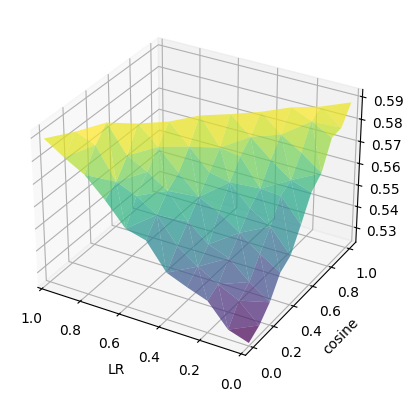

In [31]:
surface_pdf = pd.read_csv('../bin/amazon_surface_ndcg.csv')

fig = plt.figure()
ax = plt.axes(projection ='3d')
surf = ax.plot_trisurf(surface_pdf['LR'] * 4, surface_pdf['cosine'] * 4, surface_pdf['ndcg'], linewidth=0.1, alpha=0.7, color='b', cmap='viridis')

ax.set_xlabel("LR")
ax.set_ylabel("cosine")
ax.set_xlim([1,0])